In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from  multimodemodel import (
    StaggeredGrid,
    State,
    Variable,
    Parameters,
    integrate,
    adams_bashforth3,
    pressure_gradient_i,
    pressure_gradient_j,
    divergence_i,
    divergence_j,
)
from multimodemodel.API_implementation import (
    DomainState,
    GeneralSolver,
    RegularSplitMerger,
    BorderState,
    BorderMerger,
    Tail,
    ParameterSplit,
    GridSplit,
)
from multimodemodel import diag
from dask.distributed import Client, performance_report

In [2]:
client = Client(n_workers=4, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.07 GiB
Comm: tcp://127.0.0.1:40423,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.07 GiB
Comm: tcp://127.0.0.1:46613,Total threads: 1
Dashboard: http://127.0.0.1:39331/status,Memory: 3.77 GiB
Nanny: tcp://127.0.0.1:42283,


In [3]:
def staggered_grid(shape, grid_spacing):
    nx, ny = shape
    dx, dy = grid_spacing
    x = np.arange(0.0, dx * nx, dx)
    y = np.arange(0.0, dy * ny, dy)
    return StaggeredGrid.cartesian_c_grid(x, y)

In [4]:
nx, ny = 100, 100
dx, dy = 1., 1.
n_step = 500

parameter = Parameters(H=1.0)

grid = staggered_grid((nx, ny), (dx, dy))

In [5]:
def initial_condition(staggered_grid, parameter):
    nx, ny = staggered_grid.u.len_x, staggered_grid.u.len_y
    u = np.zeros((nx, ny))
    v = np.zeros((nx, ny))
    x, y = staggered_grid.eta.x, staggered_grid.eta.y
    eta = np.exp(
        -((x - x.mean()) ** 2 + (y - y.mean()) ** 2)
        / (x.max() // 5) ** 2
    )

    initial_state = State(
        u=Variable(u, staggered_grid.u),
        v=Variable(v, staggered_grid.v),
        eta=Variable(eta, staggered_grid.eta),
    )

    return DomainState.make_from_State(
        initial_state, history=deque([], maxlen=3), parameter=parameter, it=0, id=0
    )


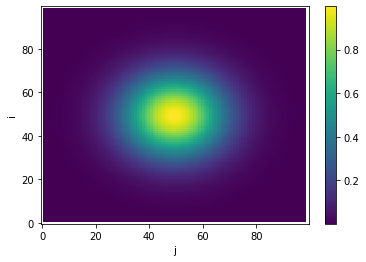

In [6]:
initial_condition(grid, parameter).eta.as_dataarray.plot()

In [7]:
def non_rotating_swe(state, params):
    rhs = (
        pressure_gradient_i(state, params)
        + pressure_gradient_j(state, params)
        + divergence_i(state, params)
        + divergence_j(state, params)
    )
    return rhs

In [8]:
def get_dt(grid, parameter):
    dx = min(grid.dx.min(), grid.dy.min())
    c = np.sqrt(parameter.H * parameter.g)
    return 0.15 * dx / c

In [9]:
def classic_API(initial_state, dt):
    state = State(initial_state.u, initial_state.v, initial_state.eta)
    for next_state in integrate(
        state,
        initial_state.parameter,
        RHS=non_rotating_swe,
        step=dt,
        time=n_step * dt,
        scheme=adams_bashforth3,
    ):
        pass
    return next_state

In [10]:
def new_API_without_split(initial_state, dt):
    gs = GeneralSolver(
        solution=non_rotating_swe,
        schema=adams_bashforth3,
        step=dt
    )
    next = initial_state
    for _ in range(n_step):
        next = gs.integration(next)
    return next

In [11]:
def new_API_with_split_no_dask(initial_state, dt, parts=4):
    border_width = 2
    dim = (0,)
    splitter = RegularSplitMerger(parts, dim)
    border_merger = BorderMerger(border_width, dim[0])
    tailor = Tail()
    gs = GeneralSolver(
        solution=non_rotating_swe,
        schema=adams_bashforth3,
        step=dt
    )

    domain_stack = deque([tailor.split_domain(initial_state, splitter)], maxlen=2)
    border_stack = deque(
        [[tailor.make_borders(sub, border_width, dim[0]) for sub in domain_stack[-1]]],
        maxlen=2,
    )
    for _ in range(n_step):
        new_borders = []
        new_subdomains = []
        for i, s in enumerate(domain_stack[-1]):
            new_borders.append(
                (
                    gs.partial_integration(
                        border=border_stack[-1][i][0],
                        domain=s,
                        neighbor_border=border_stack[-1][i - 1][1],
                        direction=False,
                        dim=dim[0],
                    ),
                    gs.partial_integration(
                        border=border_stack[-1][i][1],
                        domain=s,
                        neighbor_border=border_stack[-1][(i + 1) % (splitter.parts)][0],
                        direction=True,
                        dim=dim[0],
                    ),
                )
            )
        for i, (s, borders) in enumerate(zip(domain_stack[-1], new_borders)):
            integrated = gs.integration(s)
            new_subdomains.append(tailor.stitch(integrated, borders, dims=(0,)))
        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)

    return DomainState.merge(domain_stack[-1], splitter)


In [12]:
def _make_borders(base, width, dim, client):
    return (
        client.submit(
            BorderState.create_border,
            base, width, False, dim,
        ),
        client.submit(
            BorderState.create_border,
            base, width, True, dim,
        ),
    )

def new_API_with_split_and_dask(initial_state, dt, client, parts=4):
    border_width = 2
    dim = (1,)
    splitter = RegularSplitMerger(parts, dim)
    border_merger = BorderMerger(border_width, dim[0])
    tailor = Tail()
    gs = GeneralSolver(
        solution=non_rotating_swe,
        schema=adams_bashforth3,
        step=dt
    )

    domain_stack = deque([client.scatter(initial_state.split(splitter))], maxlen=2)
    border_stack = deque(
        [[_make_borders(sub, border_width, dim[0], client) for sub in domain_stack[-1]]],
        maxlen=2,
    )
    for _ in range(n_step):
        new_borders = []
        new_subdomains = []
        for i, s in enumerate(domain_stack[-1]):
            new_borders.append(
                (
                    client.submit(
                        gs.partial_integration,
                        border=border_stack[-1][i][0],
                        domain=s,
                        neighbor_border=border_stack[-1][i - 1][1],
                        direction=False,
                        dim=dim[0],
                    ),
                    client.submit(
                        gs.partial_integration,
                        border=border_stack[-1][i][1],
                        domain=s,
                        neighbor_border=border_stack[-1][(i + 1) % (splitter.parts)][0],
                        direction=True,
                        dim=dim[0],
                    ),
                )
            )
        for s, borders in zip(domain_stack[-1], new_borders):
            integrated = client.submit(gs.integration, s)
            new_subdomains.append(
                client.submit(
                    tailor.stitch, integrated, borders, dims=(0,)
                )
            )
        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)

    return DomainState.merge(client.gather(domain_stack[-1]), splitter)

In [13]:
def new_API_with_split_by_term_and_dask(initial_state, dt, client):

    def non_rotating_swe_with_dask(state):
        terms = [client.submit(f, state, client.submit(getattr, state, "parameter")) for f in (pressure_gradient_i, pressure_gradient_j, divergence_i, divergence_j)]
        rhs = client.submit(sum, terms[1:], terms[0])
        return rhs
    
    def append_to_history(domain_future, inc):
        domain_future.history.append(inc)
        return domain_future 

    def timestep(old):
        new = adams_bashforth3(old.history, old.parameter, dt)
        return DomainState(
            old.u + new.u,
            old.v + new.v,
            old.eta + new.eta,
            old.history,
            old.parameter,
            old.increment_iteration(),
            old.get_id(),
        )
    
    def integration(domain: DomainState) -> DomainState:
        inc = non_rotating_swe_with_dask(domain)
        domain_with_inc = client.submit(append_to_history, domain, inc)
        return client.submit(timestep, domain_with_inc)

    next = client.scatter(initial_state, broadcast=True)
    for _ in range(n_step):
        next = integration(next)
    return next.result()

In [14]:
from ray import workflow

def new_API_with_split_and_ray(initial_state, dt, parts=4):
    border_width = 2
    dim = (1,)
    splitter = RegularSplitMerger(parts, dim)
    border_merger = BorderMerger(border_width, dim[0])
    tailor = Tail()
    gs = GeneralSolver(
        solution=non_rotating_swe,
        schema=adams_bashforth3,
        step=dt
    )

    @workflow.step
    def _create_border(base, width, dir, dim):
        from multimodemodel.API_implementation import BorderState
        return BorderState.create_border(
            base, width, dir, dim
        )

    @workflow.step
    def _make_borders(base, width, dim):
        return (
            _create_border.step(
                base, width, False, dim,
            ),
            _create_border.step(
                base, width, True, dim,
            ),
        )

    @workflow.step
    def _partial_integration(
            border,
            domain,
            neighbor_border,
            direction,
            dim
    ):
        return gs.partial_integration(
            border=ray.get(border)[1 if dir else 0],
            domain=domain,
            neighbor_border=ray.get(neighbor_border)[0 if dir else 0],
            direction=direction,
            dim=dim
        )

    @workflow.step
    def _integration(s):
        return gs.integration(s)

    @workflow.step
    def _merge(domains, merger):
        from multimodemodel.API_implementation import DomainState
        return DomainState.merge(domains, merger)

    @workflow.step
    def _make_workflow(a):
        return a

    domain_stack = deque([[_make_workflow.step(sub) for sub in initial_state.split(splitter)]], maxlen=2)
    border_stack = deque(
        [[_make_borders.step(sub, border_width, dim[0]) for sub in domain_stack[-1]]],
        maxlen=2,
    )
    for _ in range(n_step):
        new_borders = []
        new_subdomains = []
        for i, s in enumerate(domain_stack[-1]):
            new_borders.append(
                (
                    _partial_integration.step(
                        border=border_stack[-1][i],
                        domain=s,
                        neighbor_border=border_stack[-1][i - 1],
                        direction=False,
                        dim=dim[0],
                    ),
                    _partial_integration.step(
                        border=border_stack[-1][i],
                        domain=s,
                        neighbor_border=border_stack[-1][(i + 1) % (splitter.parts)],
                        direction=True,
                        dim=dim[0],
                    ),
                )
            )
        for s, borders in zip(domain_stack[-1], new_borders):
            new_subdomains.append(
                _merge.step(
                    (borders[0], _integration.step(s), borders[1]),
                    border_merger,
                )
            )
        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)

    return _merge.step(domain_stack[-1], splitter).run()

In [15]:
from dask import delayed

def new_API_with_split_and_dask_on_ray(initial_state, dt, parts=4):

    def _make_borders(base, width, dim):
        return (
            delayed(BorderState.create_border)(base, width, False, dim),
            delayed(BorderState.create_border)(base, width, True, dim)
        )

    def _split():
        subs = initial_state.split(splitter)
        return [delayed(s) for s in subs]

    border_width = 2
    dim = (1,)
    splitter = RegularSplitMerger(parts, dim)
    border_merger = BorderMerger(border_width, dim[0])
    tailor = Tail()
    gs = GeneralSolver(
        solution=non_rotating_swe,
        schema=adams_bashforth3,
        step=dt
    )

    domain_stack = deque([_split()], maxlen=2)
    border_stack = deque(
        [[_make_borders(sub, border_width, dim[0]) for sub in domain_stack[-1]]],
        maxlen=2,
    )
    for _ in range(0):
        new_borders = []
        new_subdomains = []
        for i, s in enumerate(domain_stack[-1]):
            new_borders.append(
                (
                    delayed(gs.partial_integration)(
                        border=border_stack[-1][i][0],
                        domain=s,
                        neighbor_border=border_stack[-1][i - 1][1],
                        direction=False,
                        dim=dim[0],
                    ),
                    delayed(gs.partial_integration)(
                        border=border_stack[-1][i][1],
                        domain=s,
                        neighbor_border=border_stack[-1][(i + 1) % splitter.parts][0],
                        direction=True,
                        dim=dim[0],
                    ),
                )
            )
        for s, borders in zip(domain_stack[-1], new_borders):
            new_subdomains.append(
                delayed(DomainState.merge)(
                    (borders[0], delayed(gs.integration)(s), borders[1]),
                    border_merger,
                )
            )
        domain_stack.append(new_subdomains)
        border_stack.append(new_borders)

    return delayed(DomainState.merge)(domain_stack[-1], splitter).compute()

In [16]:
# numba warm up
def warm_up(grid, parameter):
    oracle = classic_API(
        initial_condition(grid, parameter),
        get_dt(grid.u, parameter)
    )
warm_up(grid, parameter)

In [17]:
%%time
oracle = classic_API(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter)
)

CPU times: user 174 ms, sys: 7.07 ms, total: 181 ms
Wall time: 173 ms


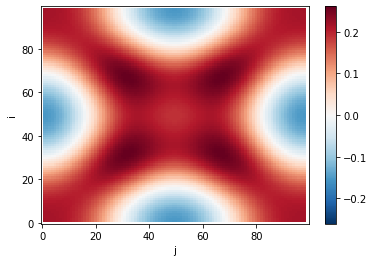

In [18]:
oracle.eta.as_dataarray.plot()

In [19]:
%%time
new_wo_split = new_API_without_split(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
)

CPU times: user 232 ms, sys: 3.64 ms, total: 236 ms
Wall time: 225 ms


In [20]:
diag.print_lru_cache_info()

lru_cache Info:
---------------
Grid.__eq__grid__               : CacheInfo(hits=0, misses=0, maxsize=1000, currsize=0)
GridSplit.split                 : CacheInfo(hits=0, misses=0, maxsize=1000, currsize=0)
GridSplit.merge.__wrapped__     : CacheInfo(hits=0, misses=0, maxsize=1000, currsize=0)
ParameterSplit.split            : CacheInfo(hits=0, misses=0, maxsize=1000, currsize=0)
ParameterSplit.merge.__wrapped__: CacheInfo(hits=0, misses=0, maxsize=1000, currsize=0)


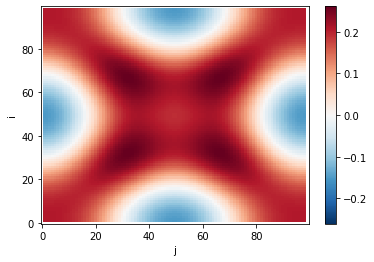

In [21]:
new_wo_split.eta.as_dataarray.plot()

In [22]:
%%time
new_with_split_no_dask = new_API_with_split_no_dask(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
    parts=4
)

CPU times: user 1.29 s, sys: 63 ms, total: 1.35 s
Wall time: 1.29 s


In [23]:
diag.print_lru_cache_info()

lru_cache Info:
---------------
Grid.__eq__grid__               : CacheInfo(hits=11976, misses=24, maxsize=1000, currsize=24)
GridSplit.split                 : CacheInfo(hits=23952, misses=75, maxsize=1000, currsize=75)
GridSplit.merge.__wrapped__     : CacheInfo(hits=11985, misses=27, maxsize=1000, currsize=27)
ParameterSplit.split            : CacheInfo(hits=4004, misses=5, maxsize=1000, currsize=5)
ParameterSplit.merge.__wrapped__: CacheInfo(hits=3999, misses=2, maxsize=1000, currsize=2)


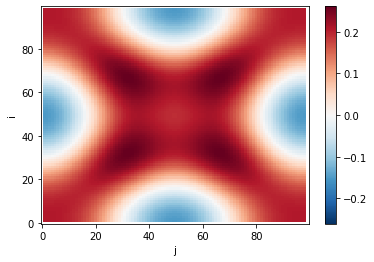

In [24]:
new_with_split_no_dask.eta.as_dataarray.plot()

In [25]:
client.run(warm_up, grid, parameter)

{'tcp://127.0.0.1:34239': None,
 'tcp://127.0.0.1:36745': None,
 'tcp://127.0.0.1:36799': None,
 'tcp://127.0.0.1:46613': None}

In [26]:
%%time
with performance_report(filename="new_with_split_and_dask.html"):
    new_with_split_and_dask = new_API_with_split_and_dask(
        initial_condition(grid, parameter),
        get_dt(grid.u, parameter),
        client
    )

CPU times: user 55.9 s, sys: 2.14 s, total: 58 s
Wall time: 1min 1s


In [27]:
client.run(diag.lru_cache_info)

{'tcp://127.0.0.1:34239': OrderedDict([('Grid.__eq__grid__',
               CacheInfo(hits=2922, misses=24, maxsize=1000, currsize=24)),
              ('GridSplit.split',
               CacheInfo(hits=5844, misses=54, maxsize=1000, currsize=54)),
              ('GridSplit.merge.__wrapped__',
               CacheInfo(hits=2922, misses=24, maxsize=1000, currsize=24)),
              ('ParameterSplit.split',
               CacheInfo(hits=980, misses=4, maxsize=1000, currsize=4)),
              ('ParameterSplit.merge.__wrapped__',
               CacheInfo(hits=981, misses=1, maxsize=1000, currsize=1))]),
 'tcp://127.0.0.1:36745': OrderedDict([('Grid.__eq__grid__',
               CacheInfo(hits=3123, misses=24, maxsize=1000, currsize=24)),
              ('GridSplit.split',
               CacheInfo(hits=6246, misses=54, maxsize=1000, currsize=54)),
              ('GridSplit.merge.__wrapped__',
               CacheInfo(hits=3123, misses=24, maxsize=1000, currsize=24)),
              ('Paramete

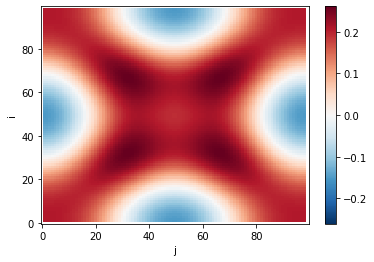

In [28]:
new_with_split_and_dask.eta.as_dataarray.plot()

In [29]:
%%time
with performance_report(filename="new_with_split_by_term_and_dask.html"):
    new_with_split_by_term_and_dask = new_API_with_split_by_term_and_dask(
        initial_condition(grid, parameter),
        get_dt(grid.u, parameter),
        client
    )

CPU times: user 24.3 s, sys: 1.14 s, total: 25.4 s
Wall time: 35.1 s


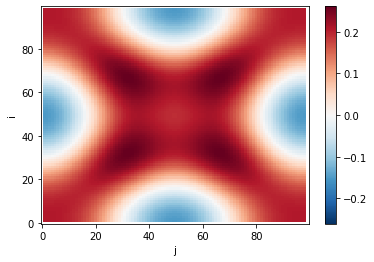

In [30]:
new_with_split_by_term_and_dask.eta.as_dataarray.plot()

In [31]:
import ray
import dask
from ray.util.dask import ray_dask_get
#ray.init(num_cpus=4)
workflow.init("/tmp/ray/workflow_data")
dask.config.set(scheduler=ray_dask_get)

2022-01-03 22:32:22,946	INFO workflow_access.py:378 -- Initializing workflow manager...


In [32]:
%%time
new_with_split_and_ray = new_API_with_split_and_ray(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
    parts=4
)

2022-01-03 22:32:23,410	INFO execution.py:49 -- Workflow job created. [id="d53a7e1c-241b-4fe8-b309-0965f682aa62.1641245543.409860611", storage_url="file:///tmp/ray/workflow_data"]. Type: FUNCTION.


RuntimeError: This event loop is already running

In [33]:
new_with_split_and_ray.eta.as_dataarray.plot()

/home/kacpern/.local/lib/python3.9/site-packages/IPython/core/ultratb.py:1366: RuntimeWarning: coroutine 'WorkflowStorage._put' was never awaited
  self.tb = tb


NameError: name 'new_with_split_and_ray' is not defined

In [34]:
%%time
new_with_split_and_dask_on_ray = new_API_with_split_and_dask_on_ray(
    initial_condition(grid, parameter),
    get_dt(grid.u, parameter),
    parts=4
)

AttributeError: type object 'VariableSplit' has no attribute 'data'

In [ ]:
new_with_split_and_dask_on_ray.eta.as_dataarray.plot()

In [ ]:
ray.shutdown()

In [ ]:
!conda list